In [1]:
import pandas as pd
import numpy as np
import catboost as catb
import xgboost as xgb
import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn import metrics

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Иморт данных

In [3]:
train = pd.read_csv('./train.csv')

### Изучение данных

In [4]:
train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [6]:
df = train.copy()

Заполенение пропусков простым способом

In [7]:
def filling_gaps(data, feature):
    data.loc[data[feature].isna(), feature] = data[feature].median()
    return data

In [8]:
filling_gaps(df, 'Annual Income')
filling_gaps(df, 'Months since last delinquent')
filling_gaps(df, 'Bankruptcies')
filling_gaps(df, 'Credit Score')

df.loc[df['Years in current job'].isna(), 'Years in current job'] = df['Years in current job'].mode()[0]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [10]:
CAT_FEATURES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [11]:
NUM_FEATURES = ['Annual Income',
                'Tax Liens',
                'Number of Open Accounts',
                'Years of Credit History',
                'Maximum Open Credit',
                'Number of Credit Problems', 
                'Months since last delinquent',
                'Bankruptcies',
                'Current Loan Amount', 
                'Current Credit Balance',
                'Monthly Debt',
                'Credit Score']

In [12]:
TARGET_FEATURE = 'Credit Default'

### Построение простой модели

In [13]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + metrics.classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + metrics.classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [14]:
def evaluate_pred(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [15]:
X = df.drop(columns='Credit Default', axis=1)
y = df[TARGET_FEATURE]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y, shuffle=True)

In [17]:
weight_min = y_train.value_counts()[0] / y_train.value_counts()[1]

In [18]:
model_xgb = xgb.XGBClassifier(random_state=2,
                              scale_pos_weight=weight_min, 
                              eval_metric='logloss',
                              learning_rate=0.01,
                              n_estimators=2000,
                              reg_lambda=100,
#                               max_depth=4
                             )

model_xgb.fit(X_train[NUM_FEATURES], y_train)

evaluate_pred(model_xgb, X_train[NUM_FEATURES], X_test[NUM_FEATURES], y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.76      0.83      4310
           1       0.57      0.79      0.66      1690

    accuracy                           0.77      6000
   macro avg       0.73      0.78      0.74      6000
weighted avg       0.81      0.77      0.78      6000

TEST

              precision    recall  f1-score   support

           0       0.83      0.69      0.76      1077
           1       0.45      0.64      0.53       423

    accuracy                           0.68      1500
   macro avg       0.64      0.67      0.64      1500
weighted avg       0.72      0.68      0.69      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               745  332
1               151  272


# EDA

**Баланс классов**

In [19]:
df = train.copy()

In [20]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

имеется дисбаланс

### Изучение признаков

**Наличие пропусков**
- Annual Income
- Months since last delinquent
- Bankruptcies
- Credit Score
- Years in current job

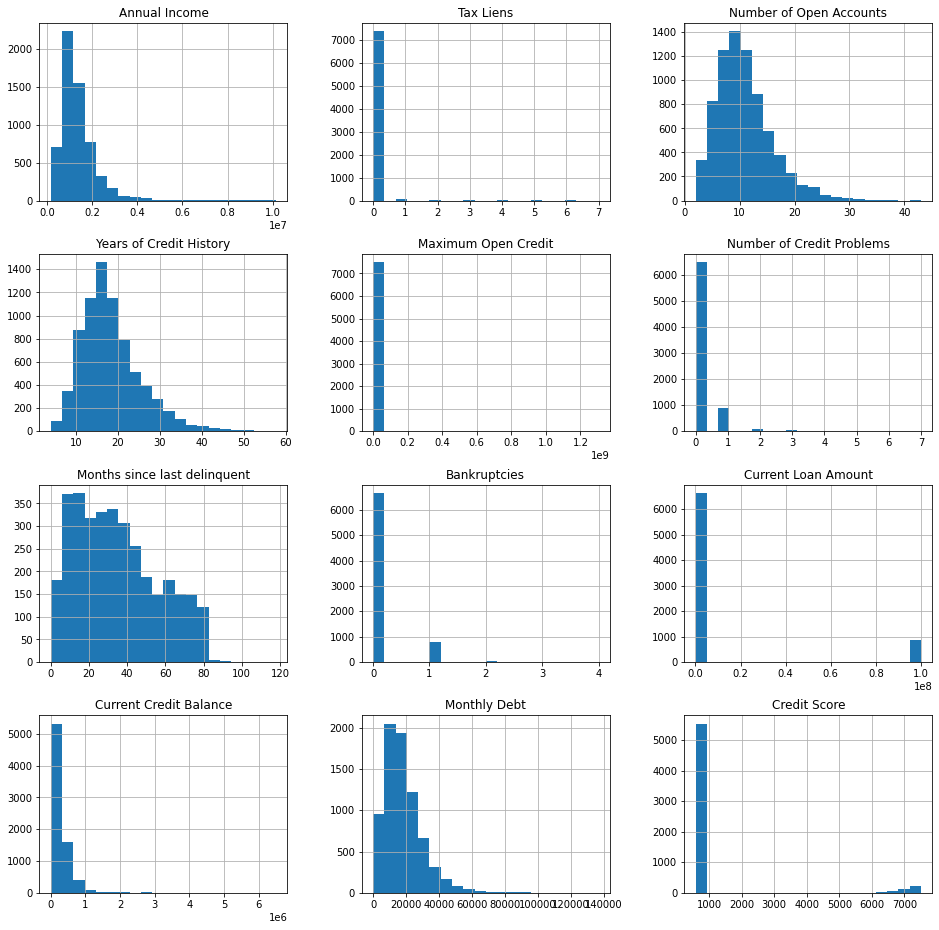

In [21]:
df[NUM_FEATURES].hist(figsize=(16, 16), bins=20)
plt.show()

**Длинный хвост (выброс)**
- Current Credit Balance
- Maximum Open Credit
- Current Loan Amount
- Months since last delinquent
- Annual Income
- Number of Open Accounts
- Years of Credit History
- Monthly Debt
- Credit History

In [22]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


наблюдаются аномалии в следующих признаках:

- Maximum Open Credit
- Current Loan Amount
- Credit Score

**Функция замены выбросов на пропуски**

In [96]:
def preprocess_outlier(data, col, threshold):
    data[f'{col}_outlier'] = False
    data.loc[data[col] > threshold, f'{col}_outlier'] = True
    data.loc[data[col] > threshold, col] = np.nan
    data[f'{col}_nan'] = False
    data.loc[data[col].isna(), f'{col}_nan'] = True
    return data

**Функция замены пропусков с помощью модели**

In [24]:
def imputer_rfr(data, target_col, depth, iterations, learning_rate, l2):
    data = data.copy()
    
    features = data.columns
    
    data = data[features]
    
    train = data[~data[target_col].isna()]
    predict_data = data[data[target_col].isna()]
    
    X = train.drop(columns=target_col)
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=21)
    
    model = catb.CatBoostRegressor(random_state=21,
                                   silent=True,
                                   cat_features=['Purpose', 'Term', 'Home Ownership', 'Years in current job'],
                                   depth=depth,
                                   iterations=iterations,
                                   learning_rate=learning_rate,
                                   reg_lambda=l2,
                                   early_stopping_rounds=100
                                  )
    
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    print(f'r2 на train: {metrics.r2_score(y_train, pred_train)}')
    print(f'r2 на test: {metrics.r2_score(y_test, pred_test)}')
    
    pred = model.predict(predict_data.drop(columns=target_col))
    
    data.loc[data[target_col].isna(), target_col] = list(pred)
    return model, data

### Влияние признаков на целевую переменную

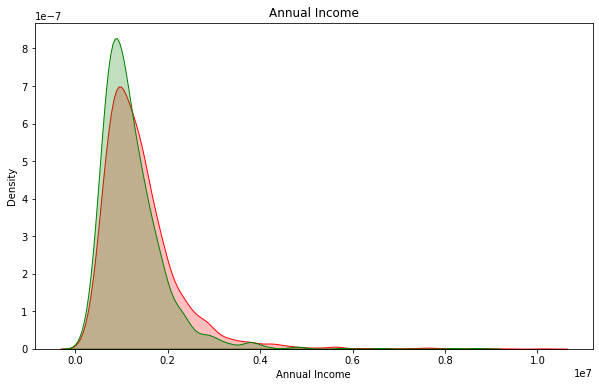

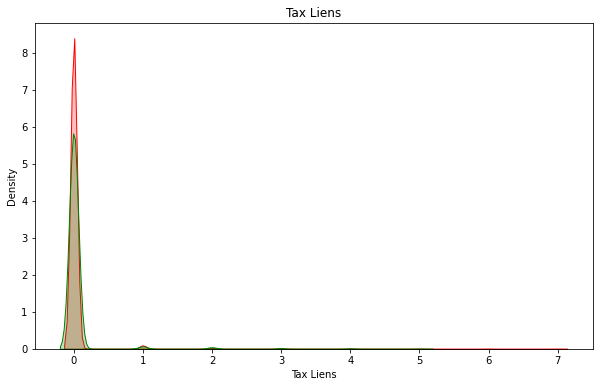

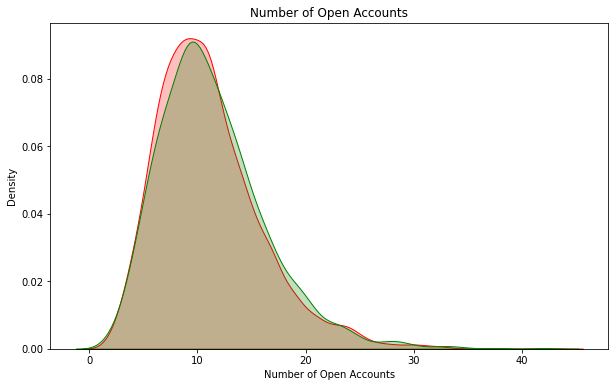

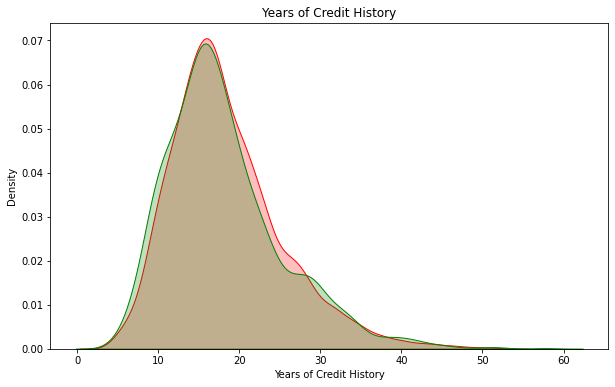

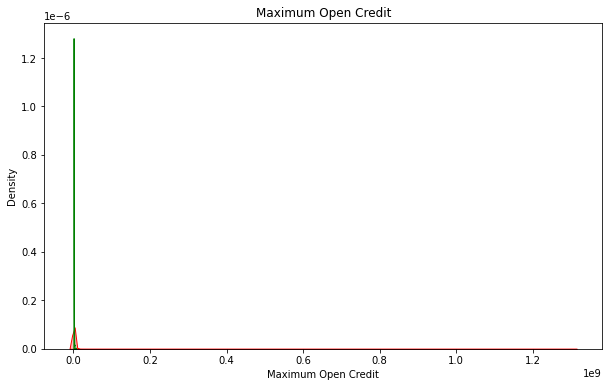

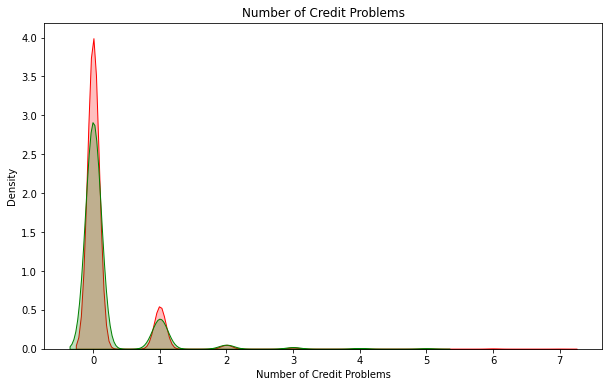

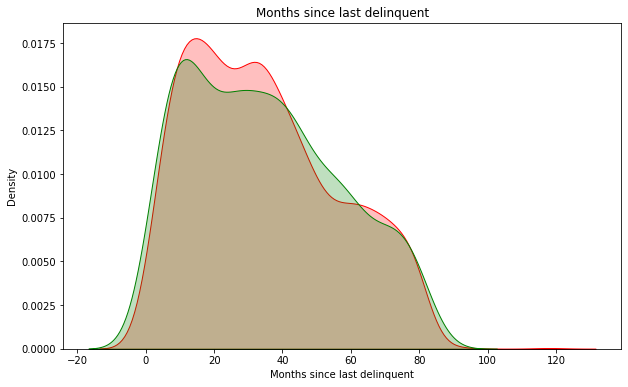

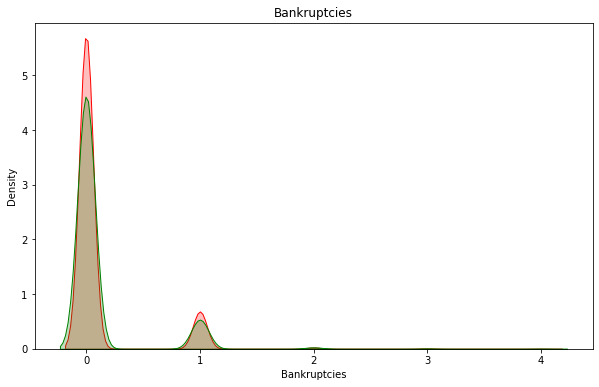

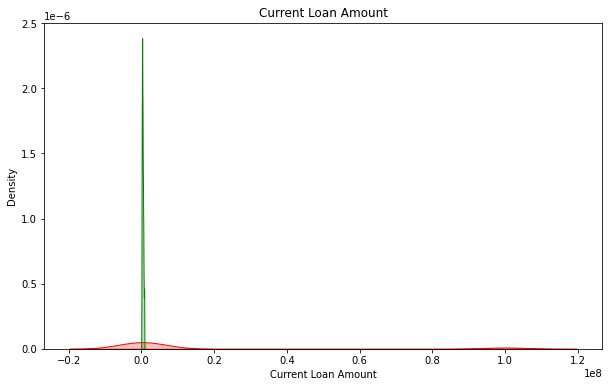

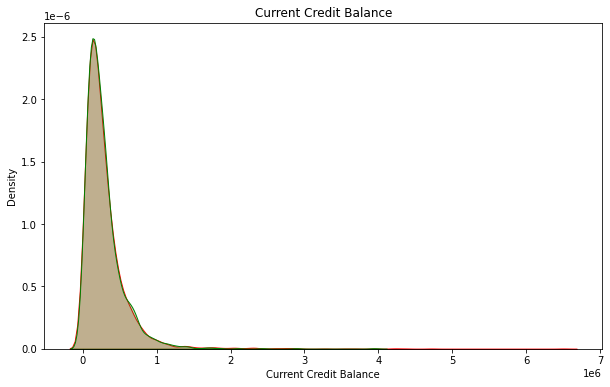

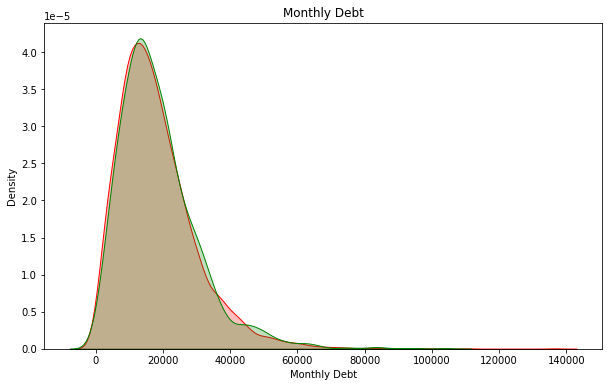

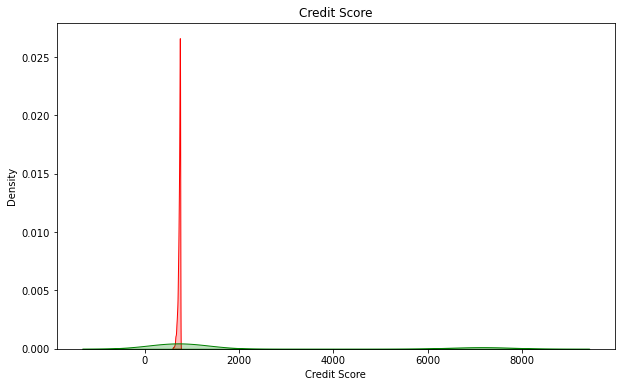

In [25]:
for feature in NUM_FEATURES:
    feature_with_target = df[[feature, TARGET_FEATURE]]
    feature = feature_with_target[feature]
    feature_0 = feature.loc[feature_with_target[TARGET_FEATURE] == 0]
    feature_1 = feature.loc[feature_with_target[TARGET_FEATURE] == 1]

    plt.figure(figsize=(10, 6))

    sns.kdeplot(feature_0, shade=True, color='r', label='0')
    sns.kdeplot(feature_1, shade=True, color='g', label='1')

    plt.title(feature.name)
    plt.show()

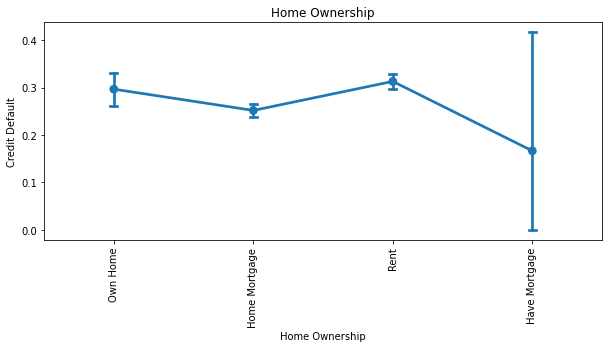

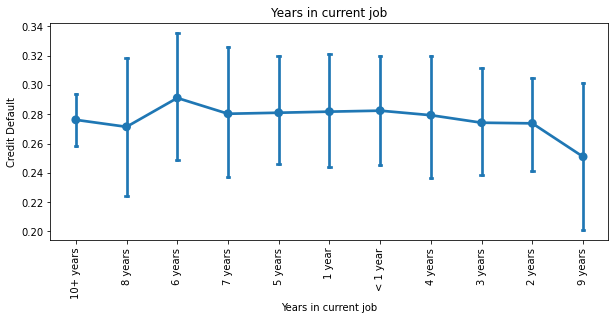

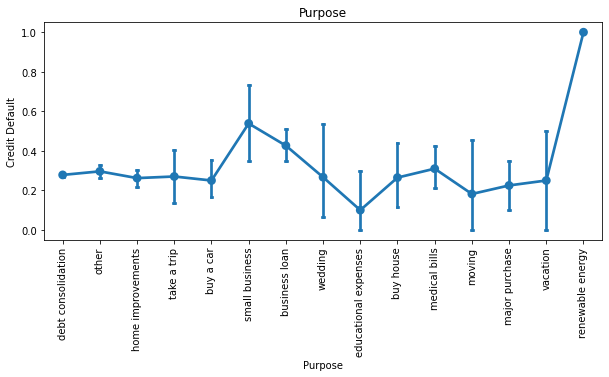

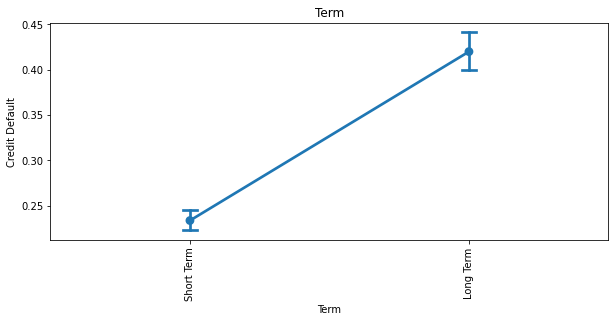

In [26]:
for feature in CAT_FEATURES:
    plt.figure(figsize=(10, 4))
    sns.pointplot(data=df, y=TARGET_FEATURE, x=feature, capsize=0.05)
    
    plt.title(feature)
    plt.xticks(rotation=90)
    plt.show()

# Предобработка данных

**Разделение данных на train и test**

In [27]:
df = train.copy()

X = df.drop(columns=TARGET_FEATURE, axis=1)
y = df[TARGET_FEATURE]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=21, shuffle=True)

y_train.value_counts()[1] / y_train.value_counts()[0], y_test.value_counts()[1] / y_test.value_counts()[0]

(0.39211136890951276, 0.39275766016713093)

### Масштабирование

In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaler = X_train.copy()
X_test_scaler = X_test.copy()

X_train_scaler[NUM_FEATURES] = scaler.fit_transform(X_train_scaler[NUM_FEATURES])
X_test_scaler[NUM_FEATURES] = scaler.transform(X_test_scaler[NUM_FEATURES])

X_test_scaler.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1182.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,672.000000,1498.000000,1500.000000,1500.000000,1500.000000,1182.000000
mean,-0.047932,0.052564,-0.001422,-0.003195,0.298277,0.023853,0.033142,0.020605,0.010245,0.027419,-0.030268,-0.003000
std,0.882314,1.369967,0.987012,1.017567,9.571588,1.093468,1.045475,1.037832,1.012841,1.106234,0.986199,0.992388
min,-1.399822,-0.109786,-1.855549,-2.040999,-0.198275,-0.342805,-1.607724,-0.335907,-0.370130,-0.926532,-1.537530,-0.347287
25%,-0.637153,-0.109786,-0.636442,-0.687169,-0.118588,-0.342805,-0.863248,-0.335907,-0.365224,-0.550747,-0.695318,-0.274475
50%,-0.237485,-0.109786,-0.230073,-0.202640,-0.066255,-0.342805,-0.118772,-0.335907,-0.361137,-0.247364,-0.204106,-0.261406
75%,0.293080,-0.109786,0.379481,0.509902,0.022722,-0.342805,0.858353,-0.335907,-0.354576,0.219029,0.411366,-0.254560
max,7.529675,23.843550,4.849540,5.611706,355.858236,11.924563,2.207716,11.273974,2.769530,14.251977,9.891729,3.956722


### Выявление аномалий (выбросов)

**Bankruptcies**

In [29]:
Bankruptcies_mode = X_train_scaler['Bankruptcies'].mode()[0]
X_train_scaler.loc[X_train_scaler['Bankruptcies'].isna(), 'Bankruptcies'] = Bankruptcies_mode

X_test_scaler.loc[X_test_scaler['Bankruptcies'].isna(), 'Bankruptcies'] = Bankruptcies_mode

In [30]:
X_train_scaler['Bankruptcies'].isna().sum()

0

**Years in current job**

In [31]:
years_in_current_job_mode = X_train_scaler["Years in current job"].mode()[0]

def years_in_current_job_fillna(data):
    data['Years in current job NaN'] = False
    data.loc[data["Years in current job"].isna(), "Years in current job NaN"] = True
    data.loc[data["Years in current job"].isna(), "Years in current job"] = years_in_current_job_mode
    return data

X_train_scaler = years_in_current_job_fillna(X_train_scaler)
X_test_scaler = years_in_current_job_fillna(X_test_scaler)

**Current Credit Balance**

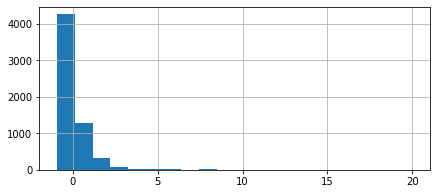

In [32]:
X_train_scaler['Current Credit Balance'].hist(figsize=(7,3), bins=20)
plt.show()

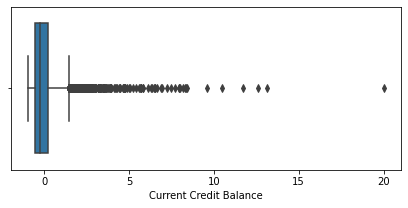

In [33]:
plt.figure(figsize=(7, 3))
sns.boxplot(data=X_train_scaler, x='Current Credit Balance')
plt.show()

In [34]:
preprocess_outlier(X_train_scaler, 'Current Credit Balance', 2)
preprocess_outlier(X_test_scaler, 'Current Credit Balance', 2)
X_train_scaler['Current Credit Balance'].isna().sum()

194

In [35]:
FEATURES_NOT_NAN = [
                    'Home Ownership',
                    'Purpose',
                    'Years in current job',
                    'Term',
#                     'Annual Income',
                    'Tax Liens',
                    'Number of Open Accounts',
                    'Years of Credit History',
                    'Maximum Open Credit',
                    'Number of Credit Problems', 
#                     'Months since last delinquent',
                    'Bankruptcies',
                    'Current Loan Amount', 
                    'Current Credit Balance',
                    'Monthly Debt',
#                     'Credit Score'
                    ]

In [36]:
model_1, X_train_scaler[FEATURES_NOT_NAN] = imputer_rfr(X_train_scaler[FEATURES_NOT_NAN], 'Current Credit Balance', None, 300, 0.05, 100)

r2 на train: 0.6954464003481564
r2 на test: 0.6710654951873841


In [37]:
def pred_test(model, data, col_name):
    df_predict = data[data[col_name].isna()]
    pred = model.predict(df_predict[FEATURES_NOT_NAN].drop(columns=col_name))
    data.loc[data[col_name].isna(), col_name] = list(pred)
    
    return data

In [38]:
X_test_scaler = pred_test(model_1, X_test_scaler, 'Current Credit Balance')

**Monthly Debt**

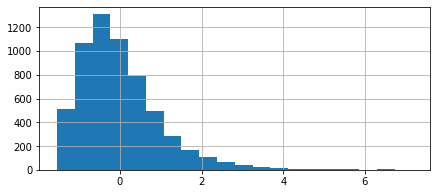

In [39]:
X_train_scaler['Monthly Debt'].hist(figsize=(7,3), bins=20)
plt.show()

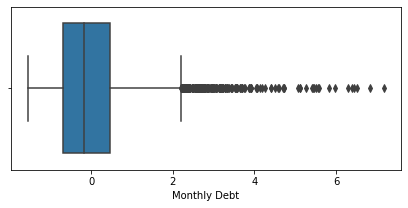

In [40]:
plt.figure(figsize=(7, 3))
sns.boxplot(data=X_train_scaler, x='Monthly Debt')
plt.show()

In [41]:
preprocess_outlier(X_train_scaler, 'Monthly Debt', 2.2)
preprocess_outlier(X_test_scaler, 'Monthly Debt', 2.2)
X_train_scaler['Monthly Debt'].isna().sum()

212

In [42]:
FEATURES_NOT_NAN = [
                    'Home Ownership',
                    'Purpose',
                    'Years in current job',
                    'Term',
#                     'Annual Income',
                    'Tax Liens',
                    'Number of Open Accounts',
                    'Years of Credit History',
                    'Maximum Open Credit',
                    'Number of Credit Problems', 
#                     'Months since last delinquent',
                    'Bankruptcies',
                    'Current Loan Amount', 
                    'Current Credit Balance',
                    'Monthly Debt',
#                     'Credit Score'
                    ]

In [43]:
 model_1, X_train_scaler[FEATURES_NOT_NAN] = imputer_rfr(X_train_scaler[FEATURES_NOT_NAN], 'Monthly Debt', 4, 100, 0.07, 100)

r2 на train: 0.40349899308751047
r2 на test: 0.3821624847432614


In [44]:
X_test_scaler = pred_test(model_1, X_test_scaler, 'Monthly Debt')

**Current Loan Amount**

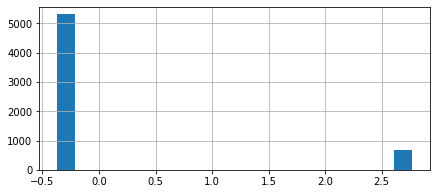

In [45]:
X_train_scaler['Current Loan Amount'].hist(figsize=(7,3), bins=20)
plt.show()

In [46]:
preprocess_outlier(X_train_scaler, 'Current Loan Amount', 2)
preprocess_outlier(X_test_scaler, 'Current Loan Amount', 2)
X_train_scaler['Current Loan Amount'].isna().sum()

692

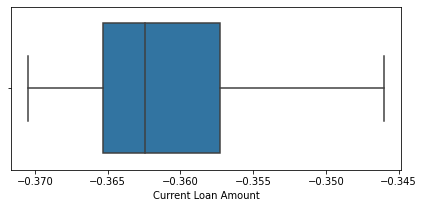

In [47]:
plt.figure(figsize=(7, 3))
sns.boxplot(data=X_train_scaler, x='Current Loan Amount')
plt.show()

In [48]:
FEATURES_NOT_NAN = [
                    'Home Ownership',
                    'Purpose',
                    'Years in current job',
                    'Term',
#                     'Annual Income',
                    'Tax Liens',
                    'Number of Open Accounts',
                    'Years of Credit History',
                    'Maximum Open Credit',
                    'Number of Credit Problems', 
#                     'Months since last delinquent',
                    'Bankruptcies',
                    'Current Loan Amount', 
                    'Current Credit Balance',
                    'Monthly Debt',
#                     'Credit Score'
                    ]

In [49]:
model_1, X_train_scaler[FEATURES_NOT_NAN] = imputer_rfr(X_train_scaler[FEATURES_NOT_NAN], 'Current Loan Amount', None, 400, None, 10)

r2 на train: 0.4885292431163576
r2 на test: 0.46459231523388167


In [50]:
X_test_scaler = pred_test(model_1, X_test_scaler, 'Current Loan Amount')

**Annual Income**

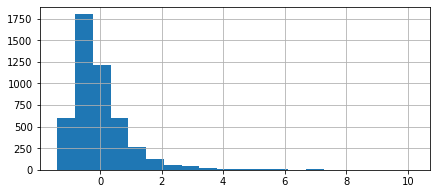

In [51]:
X_train_scaler['Annual Income'].hist(figsize=(7,3), bins=20)
plt.show()

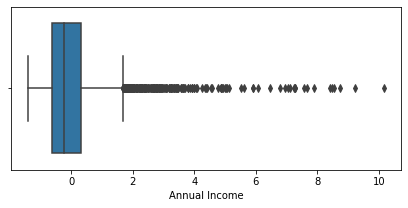

In [52]:
plt.figure(figsize=(7, 3))
sns.boxplot(data=X_train_scaler, x='Annual Income')
plt.show()

In [53]:
preprocess_outlier(X_train_scaler, 'Annual Income', 1.8)
preprocess_outlier(X_test_scaler, 'Annual Income', 1.8)
X_train_scaler['Annual Income'].isna().sum()

1442

In [54]:
FEATURES_NOT_NAN = [
                    'Home Ownership',
                    'Purpose',
                    'Years in current job',
                    'Term',
                    'Annual Income',
                    'Tax Liens',
                    'Number of Open Accounts',
                    'Years of Credit History',
                    'Maximum Open Credit',
                    'Number of Credit Problems', 
#                     'Months since last delinquent',
                    'Bankruptcies',
                    'Current Loan Amount', 
                    'Current Credit Balance',
                    'Monthly Debt',
#                     'Credit Score'
                    ]

In [55]:
model_1, X_train_scaler[FEATURES_NOT_NAN] = imputer_rfr(X_train_scaler[FEATURES_NOT_NAN], 'Annual Income', 5, 200, 0.05, 10)

r2 на train: 0.48150991901851636
r2 на test: 0.4615275768006535


In [56]:
X_test_scaler = pred_test(model_1, X_test_scaler, 'Annual Income')

**Credit Score**

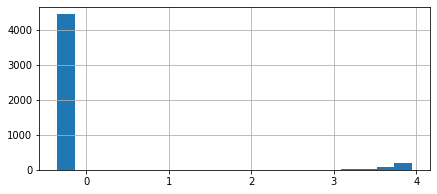

In [57]:
X_train_scaler['Credit Score'].hist(figsize=(7,3), bins=20)
plt.show()

In [58]:
preprocess_outlier(X_train_scaler, 'Credit Score', 0)
preprocess_outlier(X_test_scaler, 'Credit Score', 0)
X_train_scaler['Credit Score'].isna().sum()

1560

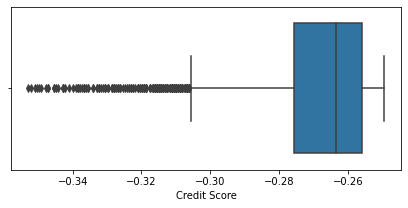

In [59]:
plt.figure(figsize=(7, 3))
sns.boxplot(data=X_train_scaler, x='Credit Score')
plt.show()

In [60]:
X_train_scaler.loc[X_train_scaler['Credit Score'] < -0.31, 'Credit Score'] = np.nan
X_test_scaler.loc[X_test_scaler['Credit Score'] < -0.31, 'Credit Score'] = np.nan

In [61]:
FEATURES_NOT_NAN = [
                    'Home Ownership',
                    'Purpose',
                    'Years in current job',
                    'Term',
                    'Annual Income',
                    'Tax Liens',
                    'Number of Open Accounts',
                    'Years of Credit History',
                    'Maximum Open Credit',
                    'Number of Credit Problems', 
#                     'Months since last delinquent',
                    'Bankruptcies',
                    'Current Loan Amount',
                    'Current Credit Balance',
                    'Monthly Debt',
                    'Credit Score'
                    ]

In [62]:
model_1, X_train_scaler[FEATURES_NOT_NAN] = imputer_rfr(X_train_scaler[FEATURES_NOT_NAN], 'Credit Score', None, 300, 0.05, 100)

r2 на train: 0.3610557286569469
r2 на test: 0.2805370188263947


In [63]:
X_test_scaler = pred_test(model_1, X_test_scaler, 'Credit Score')

**Months since last delinquent**

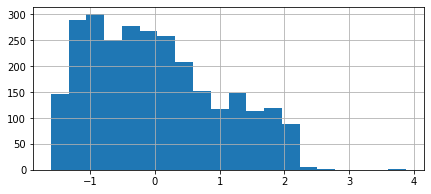

In [64]:
X_train_scaler['Months since last delinquent'].hist(figsize=(7,3), bins=20)
plt.show()

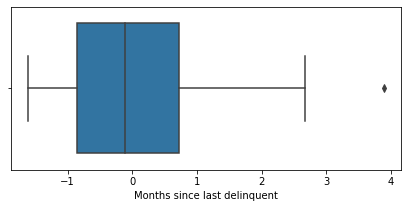

In [65]:
plt.figure(figsize=(7, 3))
sns.boxplot(data=X_train_scaler, x='Months since last delinquent')
plt.show()

In [66]:
preprocess_outlier(X_train_scaler, 'Months since last delinquent', 2.3)
preprocess_outlier(X_test_scaler, 'Months since last delinquent', 2.3)
X_train_scaler['Months since last delinquent'].isna().sum()

3258

In [67]:
FEATURES_NOT_NAN = [
                    'Home Ownership',
                    'Purpose',
                    'Years in current job',
                    'Term',
                    'Annual Income',
                    'Tax Liens',
                    'Number of Open Accounts',
                    'Years of Credit History',
                    'Maximum Open Credit',
                    'Number of Credit Problems',
                    'Months since last delinquent',
                    'Bankruptcies',
                    'Current Loan Amount',
                    'Current Credit Balance',
                    'Monthly Debt',
                    'Credit Score'
                    ]

In [68]:
model_1, X_train_scaler[FEATURES_NOT_NAN] = imputer_rfr(X_train_scaler[FEATURES_NOT_NAN], 'Months since last delinquent', None, 300, None, None)

r2 на train: 0.47441896492820623
r2 на test: -0.01207740986709882


In [69]:
X_test_scaler = pred_test(model_1, X_test_scaler, 'Months since last delinquent')

## Проверка модели

In [70]:
CAT_FEATURES = ['Home Ownership',
                'Years in current job',
                'Purpose',
                'Term']

In [71]:
X_train_scaler.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Years in current job NaN',
       'Current Credit Balance_nan', 'Monthly Debt_nan',
       'Current Loan Amount_nan', 'Annual Income_nan', 'Credit Score_nan',
       'Months since last delinquent_nan'],
      dtype='object')

In [72]:
NUM_FEATURES = [
#                 'Home Ownership',
                'Annual Income',
#                 'Years in current job',
                'Tax Liens', 
                'Number of Open Accounts',
                'Years of Credit History',
                'Maximum Open Credit',
                'Number of Credit Problems',
                'Months since last delinquent',
                'Bankruptcies',
#                 'Purpose',
#                 'Term',
                'Current Loan Amount',
                'Current Credit Balance',
                'Monthly Debt',
                'Credit Score',
#                 'Years in current job NaN',
#                 'Current Credit Balance_nan',
#                 'Monthly Debt_nan',
#                 'Current Loan Amount_nan',
#                 'Annual Income_nan',
#                 'Credit Score_nan',
#                 'Months since last delinquent_nan'
]

In [73]:
from scipy import stats

Annual Income
MannwhitneyuResult(statistic=4520788.0, pvalue=0.7816663188185657)


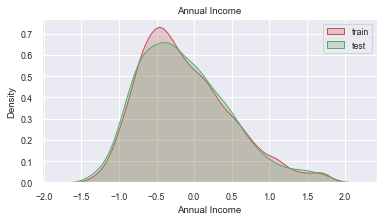

Tax Liens
MannwhitneyuResult(statistic=4494995.0, pvalue=0.7712089999757603)


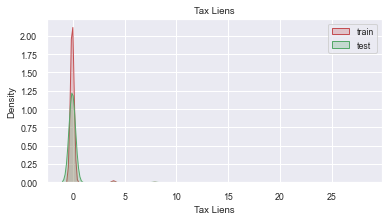

Number of Open Accounts
MannwhitneyuResult(statistic=4492502.0, pvalue=0.920176729940303)


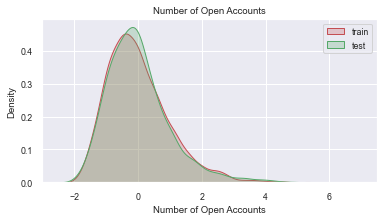

Years of Credit History
MannwhitneyuResult(statistic=4537794.0, pvalue=0.6143392983564195)


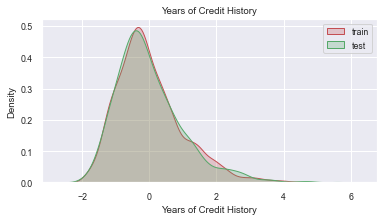

Maximum Open Credit
MannwhitneyuResult(statistic=4411678.5, pvalue=0.2389819480691211)


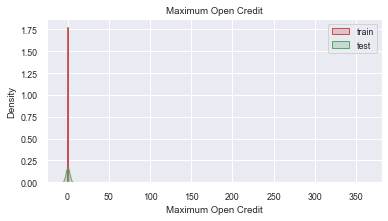

Number of Credit Problems
MannwhitneyuResult(statistic=4484604.0, pvalue=0.7310803391918215)


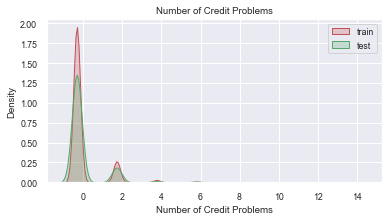

Months since last delinquent
MannwhitneyuResult(statistic=4485433.5, pvalue=0.8460174535661436)


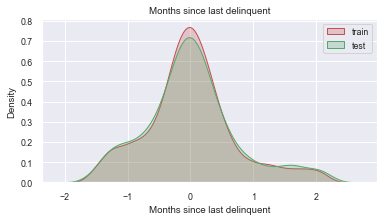

Bankruptcies
MannwhitneyuResult(statistic=4470899.5, pvalue=0.4744281164722286)


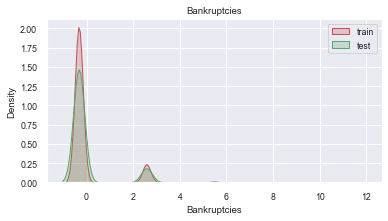

Current Loan Amount
MannwhitneyuResult(statistic=4556627.0, pvalue=0.45026717447121123)


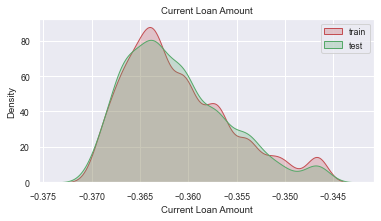

Current Credit Balance
MannwhitneyuResult(statistic=4442961.0, pvalue=0.4469780106730675)


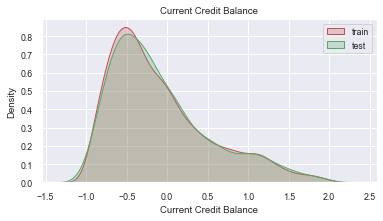

Monthly Debt
MannwhitneyuResult(statistic=4544774.0, pvalue=0.550547300316272)


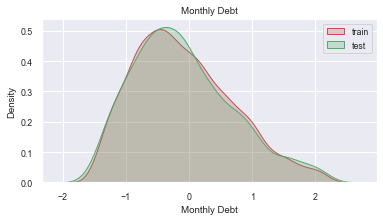

Credit Score
MannwhitneyuResult(statistic=4384123.0, pvalue=0.12234018834117323)


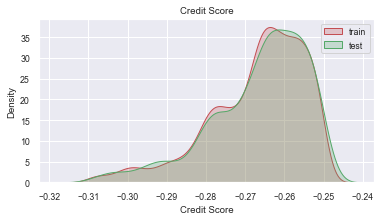

In [74]:
for col in NUM_FEATURES:
    plt.figure(figsize=(6, 3))
    sns.set(font_scale=0.8)
    sns.kdeplot(X_train_scaler[col], shade=True, label='train', color='r')
    sns.kdeplot(X_test_scaler[col], shade=True, label='test', color='g')
    print(col)
    print(stats.mannwhitneyu(X_train_scaler[col], X_test_scaler[col]))
    plt.legend()
    plt.title(col)
    plt.show()

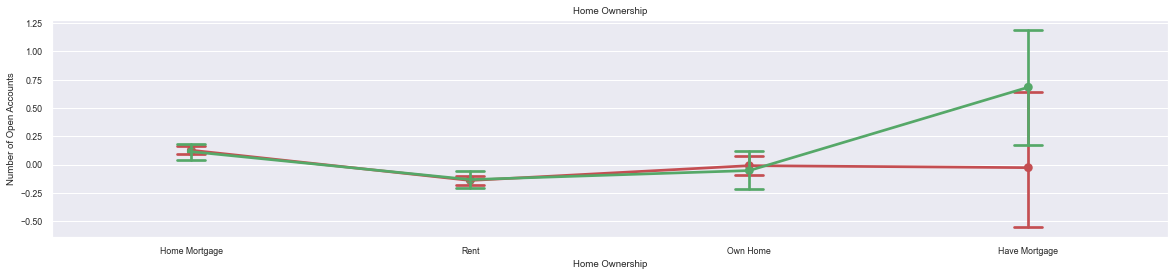

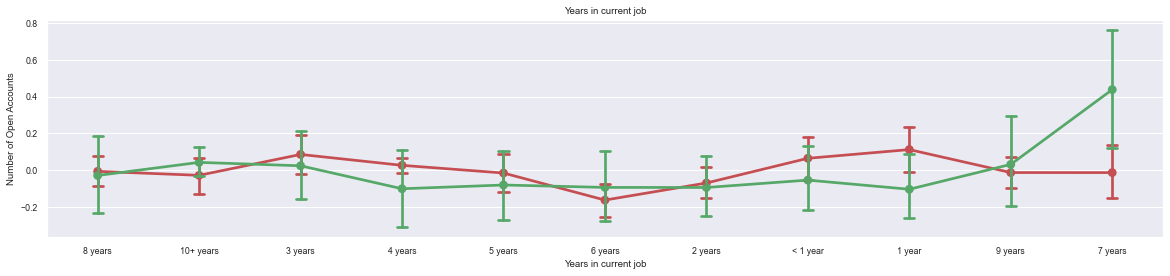

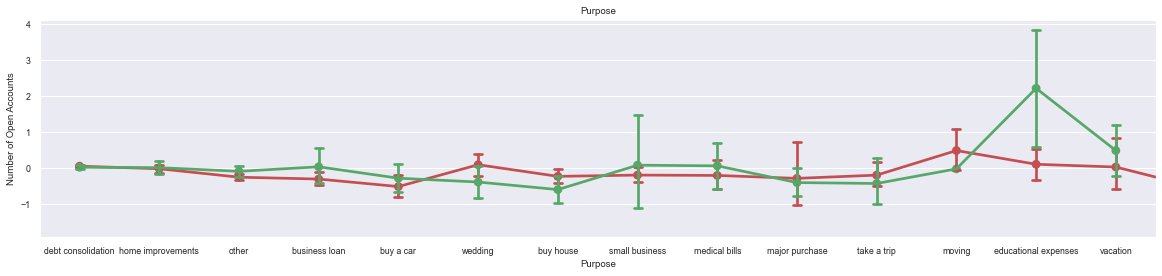

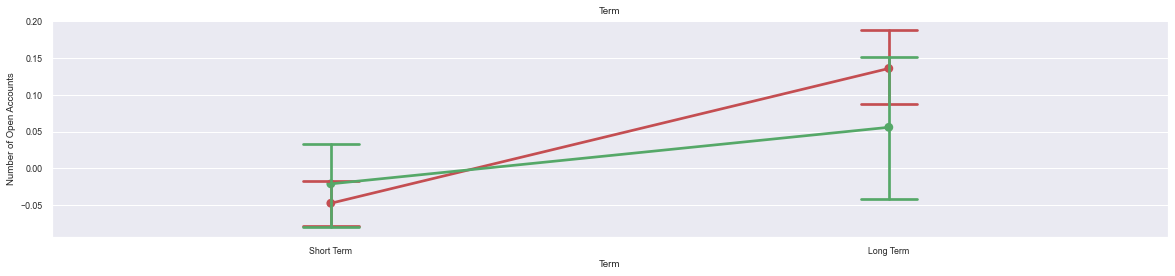

In [75]:
num_feature = 'Number of Open Accounts'
for col in CAT_FEATURES:
    plt.figure(figsize=(20, 4))
    sns.pointplot(x=col, y=num_feature, data=X_train_scaler, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=X_test_scaler, capsize=.1, label='test', color='g')
    plt.title(col)
    plt.show()

In [76]:
# def del_columns_purpose(data):
#     data = data.drop(index=data.loc[data['Purpose'].isin(['moving', 'renewable energy', 'educational expenses'])].index)
#     return data

# X_train_scaler = del_columns_purpose(X_train_scaler)
# X_test_scaler = del_columns_purpose(X_test_scaler)

In [77]:
def change_home_ownership(data):
    data.loc[data['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
    return data

X_train_scaler = change_home_ownership(X_train_scaler)
X_test_scaler = change_home_ownership(X_test_scaler)

### Создание бинарных переменных

In [78]:
def home_dummies(data):
    data_home = pd.get_dummies(data["Home Ownership"]).astype(bool)
    data = pd.concat([data, data_home], axis=1)
    return data

In [79]:
X_train_scaler = home_dummies(X_train_scaler)
X_test_scaler = home_dummies(X_test_scaler)

In [80]:
def term_dummies(data):
    data_term = pd.get_dummies(data["Term"]).astype(bool)
    data = pd.concat([data, data_term], axis=1)
    return data

In [81]:
X_train_scaler = term_dummies(X_train_scaler)
X_test_scaler = term_dummies(X_test_scaler)

In [82]:
def purpose_dummies(data):
    data_purpose = pd.get_dummies(data["Purpose"]).astype(bool)
    data = pd.concat([data, data_purpose], axis=1)
    return data

In [83]:
X_train_scaler = purpose_dummies(X_train_scaler)
X_test_scaler = purpose_dummies(X_test_scaler)

### Target encoding

In [84]:
df_cat = pd.concat([X_train_scaler, y_train], axis=1).groupby('Term', as_index=False).mean()[['Term', 'Credit Default']].rename(
    columns={'Credit Default': 'target_encode_term'})

df_cat

,Term,target_encode_term
0,Long Term,0.421694
1,Short Term,0.232553


In [85]:
X_train_scaler = X_train_scaler.merge(df_cat, on='Term', how='left')
X_test_scaler = X_test_scaler.merge(df_cat, on='Term', how='left')

In [86]:
df_cat = pd.concat([X_train_scaler, y_train], axis=1).groupby('Home Ownership', as_index=False).mean()[['Home Ownership', 'Credit Default']].rename(
    columns={'Credit Default': 'target_encode_years_in_current_job'})
df_cat

,Home Ownership,target_encode_years_in_current_job
0,Home Mortgage,0.272492
1,Own Home,0.290865
2,Rent,0.276616


In [87]:
X_train_scaler = X_train_scaler.merge(df_cat, on='Home Ownership', how='left')
X_test_scaler = X_test_scaler.merge(df_cat, on='Home Ownership', how='left')

In [88]:
X_train_scaler

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,medical bills,moving,other,renewable energy,small business,take a trip,vacation,wedding,target_encode_term,target_encode_years_in_current_job
0,Home Mortgage,-0.595001,2 years,-0.109786,-0.636442,-0.345148,-0.011042,-0.342805,-0.304891,-0.335907,...,False,False,False,False,False,False,False,False,0.232553,0.272492
1,Rent,-0.138959,1 year,15.859105,-1.245995,-1.114694,-0.164762,9.880002,0.067347,-0.335907,...,False,False,False,False,False,False,False,False,0.232553,0.276616
2,Rent,-0.707253,7 years,-0.109786,-0.433257,0.965930,-0.082901,-0.342805,0.362990,-0.335907,...,False,False,False,False,False,False,False,False,0.232553,0.276616
3,Home Mortgage,-0.746311,10+ years,-0.109786,1.395404,0.011123,-0.039313,-0.342805,1.091002,-0.335907,...,False,False,False,False,False,False,False,False,0.421694,0.272492
4,Rent,-1.054955,10+ years,-0.109786,-1.042811,-0.972186,-0.143442,-0.342805,0.105470,-0.335907,...,False,False,False,False,False,False,False,False,0.232553,0.276616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,Rent,-0.829858,2 years,-0.109786,-1.042811,-1.413962,-0.170970,-0.342805,-0.242040,-0.335907,...,False,False,False,False,False,False,False,False,0.232553,0.276616
5996,Rent,-0.205119,3 years,-0.109786,1.192219,-0.900931,-0.015112,-0.342805,0.251162,-0.335907,...,False,False,False,False,False,False,False,False,0.232553,0.276616
5997,Rent,0.104931,5 years,-0.109786,-0.433257,-0.088633,-0.163987,1.701757,0.549099,2.566563,...,False,False,False,False,False,False,False,False,0.232553,0.276616
5998,Rent,0.035320,5 years,-0.109786,0.582665,-0.929433,-0.100960,-0.342805,0.125695,-0.335907,...,False,False,False,False,False,False,False,False,0.421694,0.276616


In [89]:
CAT_FEATURES = ['Home Ownership',
                'Years in current job',
                'Purpose',
                'Term']

In [90]:
X_train_scaler.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Years in current job NaN',
       'Current Credit Balance_nan', 'Monthly Debt_nan',
       'Current Loan Amount_nan', 'Annual Income_nan', 'Credit Score_nan',
       'Months since last delinquent_nan', 'Home Mortgage', 'Own Home', 'Rent',
       'Long Term', 'Short Term', 'business loan', 'buy a car', 'buy house',
       'debt consolidation', 'educational expenses', 'home improvements',
       'major purchase', 'medical bills', 'moving', 'other',
       'renewable energy', 'small business', 'take a trip', 'vacation',
       'wedding', 'target_encode_term', 'target_encode_years_in_current_job'],
      dtype='object')

In [91]:
NUM_FEATURES = [
#     'Home Ownership',
    'Annual Income',
    'Years in current job',
    'Tax Liens',
    'Number of Open Accounts',
    'Years of Credit History',
    'Maximum Open Credit',
    'Number of Credit Problems',
    'Months since last delinquent',
    'Bankruptcies',
    'Purpose',
    'Term',
    'Current Loan Amount',
    'Current Credit Balance',
    'Monthly Debt',
    'Credit Score',
    'Years in current job NaN',
#     'Current Credit Balance_nan',
#     'Monthly Debt_nan',
    'Current Loan Amount_nan',
#     'Annual Income_nan',
    'Credit Score_nan',
    'Months since last delinquent_nan',
#     'Home Mortgage',
    'Own Home',
#     'Rent',
#     'Long Term',
#     'Short Term',
    'business loan',
#     'buy a car',
#     'buy house',
#     'debt consolidation',
#     'home improvements',
#     'major purchase',
#     'medical bills',
#     'other',
#     'small business',
#     'take a trip',
#     'vacation',
#     'wedding',
#     'target_encode_term',
    'target_encode_years_in_current_job'
]

In [92]:
catb_model = catb.CatBoostClassifier(silent=True, random_state=2,
                                    early_stopping_rounds=100,
                                    cat_features=[
                                                'Purpose',
                                                'Term',
                                                'Years in current job',
#                                                 'Home Ownership'
                                                 ]
                                    )

catb_model.fit(X_train_scaler[NUM_FEATURES], y_train)

pred_train = catb_model.predict(X_train_scaler[NUM_FEATURES])
pred_test = catb_model.predict(X_test_scaler[NUM_FEATURES])

print('TRAIN\n', round(metrics.f1_score(y_train, pred_train), 3))
print('TEST\n', round(metrics.f1_score(y_test, pred_test), 3))

TRAIN
 0.678
TEST
 0.406


TRAIN
 0.678
TEST
 0.406

In [95]:
feature_importances = pd.DataFrame(zip(X_train_scaler[NUM_FEATURES].columns, catb_model.feature_importances_),
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
16,Current Loan Amount_nan,27.227171
0,Annual Income,9.130763
14,Credit Score,8.650083
17,Credit Score_nan,6.210102
4,Years of Credit History,6.165514
13,Monthly Debt,5.957777
11,Current Loan Amount,5.845671
5,Maximum Open Credit,5.476745
12,Current Credit Balance,4.940810
7,Months since last delinquent,4.866660
